# Lab on Bandit Algorithms

Author: Claire Vernade (first.last@gmail.com)

In [1]:
import numpy as np
from model import Environment
from agent import Agent
from display import plot_regret

import seaborn as sns
colors = sns.color_palette('colorblind')

## First step : the Bandit environment
We have bandit environment is a very simple RL environment:
* There is only 1 state: this means actions do not imply change of state
* There are K actions
* The reward function are only action-dependent

### Can you implement such class, inheriting from the Environment mother class used in previous practical sessions ? 

In [5]:
class Bandit(Environment):
    
    def __init__(self, means, model='gaussian', var=1.):
        self.model = model
        self.K = np.size(means)
        self.means = means
        self.var = var
        
    def get_reward(self, action):
    
        """ sample reward given action and the model of this bandit environment"""
        if self.model == 'gaussian':
            return np.random.normal(means[action], scale=self.var)
        elif self.model == 'bernoulli' :
            return np.random.binomial(1,means[action])
        else:  #add bernoulli model option
            raise NotImplementedError('only Gaussian rewards are implemented so far')
        
        

### Remarks / Questions:
* The bandit environment is characterized by the family of distributions of the actions, here controlled by the keywork "model";
* Building this envrionment, we assumed that the models admissible are parametrized by their mean *only*. Note in particular that the experimenter needs to fix the variance of the Gaussian for all arms (here with only one value, but there could be one value per arm as long as these values are known and fixed). Keep in mind that the variance is known, it is important in the construction of UCB and Thompson Sampling later. 
* It will be useful for the rest of this session to be able to sample binary rewards. Can you implement a new model option 'bernoulli' and the according reward sampling function ?

## Second step: Bandit agents
We have seen in class a variety of bandit algorithms, ranging from the most simple policies ($\epsilon$-greedy,...) to the (near-)optimal UCB. But so far we only gave *theoretical* guarantees, that hold under a set of hypotheses... note also the heavy usage of big-O notations in those theorems: this means there are hidden constants everywhere!  *It is always a good scientific practice to empirically validate the theoretical claims*, so we are going to do just that :)

For that purpose we need a few more things: 
* Bandit agents, which shall inherit from the Agent class: we will implement $\epsilon$-greedy, Explore-Then-Commit and UCB,
* We recommend that you start with $\epsilon$-greedy and test it using Section 3 before moving on to more complex agents. 

In [53]:
class EpsGreedy(Agent):
    
    def __init__(self, environment, epsilon):
        """ 
        instantiate the agent using only the available information from the environment (i.e. not the means)
        => environment only provides K (number of available actions) here.
        """
        self.epsilon = epsilon
        self.K = environment.K
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0
        
    def get_action(self):
        if self.t < self.K:
            action = self.t
            self.t +=1
            self.count_actions[action] += 1
            return action
        else:
            empirical_means = self.count_rewards / self.count_actions ## WARNING !

            #implement epsilon-greedy: TODO

            expl = np.random.random()
            if expl < self.epsilon :
              action = np.random.randint(0,high=self.K)
            else :
              action = np.argmax(empirical_means)
           
            self.count_actions[action] += 1
            self.t += 1
            return action
        
    def receive_reward(self, action, reward):
        self.count_rewards[action] += reward
        
    def reset(self):
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0
        
    def name(self):
        return 'eps-greedy('+str(self.epsilon)+')'
        

class ETC(Agent):
    
    def __init__(self, environment, m):
        " instantiate the agent using only the available information from the environment (i.e. not the means)"
        self.m = m
        self.K = environment.K
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0  
    
    def get_action(self):
        ## TODO: implement ETC
        if self.t < self.K * self.m :
          action = self.t % self.K
          self.t += 1
          self.count_actions[action] += 1
          return action
        else : 
          empirical_means = self.count_rewards / self.count_actions
          action = np.argmax(empirical_means)
          self.t += 1
          return action
        
    def receive_reward(self, action, reward):
        # this function is written for you to help you
        if self.t < self.m * self. K: # hint: only update counts during exploration
            self.count_rewards[action] += reward
            
        # NOTE: the implementation could be done differently, this is just a suggestion
        
    def reset(self):
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0
        
    def name(self):
        return 'ETC('+str(self.m)+')'
    
    
class UCB(Agent):
    def __init__(self, environment, var, delta):
        self.K = environment.K
        self.var = var
        self.delta = delta
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0  
        
    def get_action(self):
        ## TODO: Implement UCB
        if self.t < self.K :
          action = self.t % self.K
          self.t +=1
          self.count_actions[action] += 1
          #action = np.random.randint(0,high=self.K)
          return action
        else : 
          empirical_means = self.count_rewards / self.count_actions
          ucb = empirical_means + np.sqrt(2*self.var*np.log(self.t^3) / self.count_actions)
          action = np.argmax(ucb)
          self.t +=1
          self.count_actions[action] += 1 
          return action 

    def receive_reward(self, action, reward):
        self.count_rewards[action] += reward
        
    def reset(self):
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0
        
    def name(self):
        return 'UCB('+str(self.delta)+','+str(self.var)+')'        
            
        

## Third Step: Play !
We have an environment and a policy, we now must make them play together and collect the data so that we can observe the results.

The theorems that bound the regret are either in expectation or with high probability, so to validate them empirically, we need to observ *more than one game*. This is a very important part of these experiments: we want to build a monte-carlo estimator of the regret, which plays several games and allows us to observe some statistics of all trajectories. This will allow us to control that the regret does not "explode" once in a while, and that the *expectation* over environment (and agent) randomness is under control.

### Building a game player, with regret loader:
* We want to play a T-step game (horizon T) between an environment and an agent
* We want to record the regret of our agent at every step (the agent does *not* see this!)
* We want to be able to compare agents on a fixed environment

In [33]:
def play(environment, agent, Nmc, T):
    
    data = np.zeros((Nmc, T))
    best_reward = np.max(environment.means)
    
    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            
            action = agent.get_action()
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)
            data[n,t]= best_reward - reward
            
    return agent.name(), data


def experiment(environment, agents, Nmc, T):
    
    all_data = {}
    
    for agent in agents:
        agent_id, regrets = play(environment, agent,Nmc, T)
        
        all_data[agent_id] = regrets
        
    return all_data

## Observe the results and make critical observations

We are now ready to run an experiment and observe the results


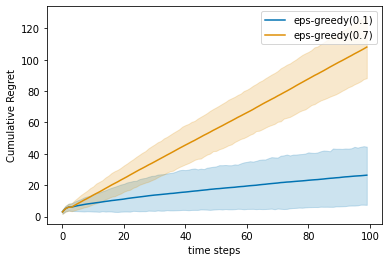

In [31]:
means = np.array([0., 1., 2., 3.])
basicGaussianBandit = Bandit(means)
agent1 = EpsGreedy(basicGaussianBandit, epsilon=0.1)
agent2 = EpsGreedy(basicGaussianBandit, epsilon=0.7)

all_data = experiment(basicGaussianBandit, [agent1, agent2], Nmc=1000, T=100)

plot_regret(all_data)

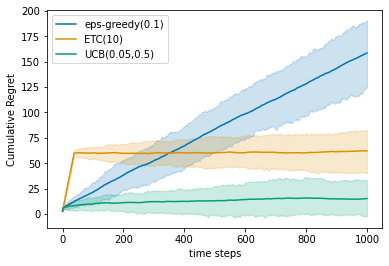

In [54]:
means = np.array([0., 1., 2., 3.])
basicGaussianBandit = Bandit(means, var=0.5)
agent1 = EpsGreedy(basicGaussianBandit, epsilon=0.1)
agent2 = ETC(basicGaussianBandit, m=10)
agent3 = UCB(basicGaussianBandit, var=0.5, delta=0.05)

all_data = experiment(basicGaussianBandit, [agent1, agent2, agent3], Nmc=100, T=1000)
plot_regret(all_data)

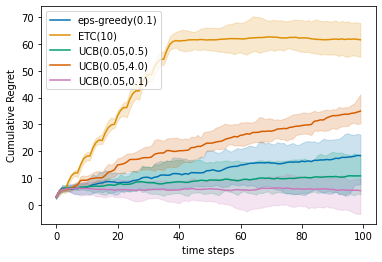

In [55]:
means = np.array([0., 1., 2., 3.])
basicGaussianBandit = Bandit(means, var=0.5)
agent1 = EpsGreedy(basicGaussianBandit, epsilon=0.1)
agent2 = ETC(basicGaussianBandit, m=10)
agent3 = UCB(basicGaussianBandit, var=0.5, delta=0.05)
badUCB = UCB(basicGaussianBandit, var=4., delta=0.05)
lowvarUCB = UCB(basicGaussianBandit, var=0.1, delta=0.05)

all_data = experiment(basicGaussianBandit, [agent1, agent2, agent3, badUCB, lowvarUCB], Nmc=10, T=100)
plot_regret(all_data)

### Critical observations:
* Do it seem right ? Remember that we are trying to validate theory so we should be able to check that the theorem is true. If not... two options: out code has a big or our theorem proof has a bug :S (or hypotheses are violated).
* What is the shape of the regret ? Do you think this policy is consistent ? Optimal ? How could you check ? 
* Which policy is the best? Is it statistically significant ?
* Can we do better ? (see Step 5 for more)



AttributeError: ignored

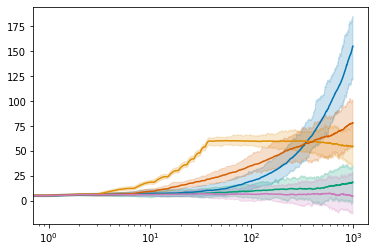

In [56]:
means = np.array([0., 1., 2., 3.])
basicGaussianBandit = Bandit(means, var=0.5)
agent1 = EpsGreedy(basicGaussianBandit, epsilon=0.1)
# agent2 = ETC(basicGaussianBandit, m=10)
agent3 = UCB(basicGaussianBandit, var=0.5, delta=0.05)
badUCB = UCB(basicGaussianBandit, var=4., delta=0.05)
lowvarUCB = UCB(basicGaussianBandit, var=0.1, delta=0.05)

all_data = experiment(basicGaussianBandit, [agent1, agent2, agent3, badUCB, lowvarUCB], Nmc=50, T=1000)
plot_regret(all_data, logscale=True)

### Conclusion:

Please write your conclusions and observations: is there something strange, can you explain everything on these plots ?

## Step 4: Your experimental benchmark

To validate all the theorems seen in class, it remains to code and test a few policies:
* Implement Explore-Then-Commit and compare it to espilon-greedy
* Implement UCB (pay attention to input parameters) and compare it to Explore-Then-Commit and Epsilon-Greedy

Do plot everything and write a few comment line below each plot to comment critically on the obtained results. 

## Step 5: Optimality check

As seen in class, there is a theoretical way to check that a policy is (close to) optimal: compare its regret with the lower bound. 

In [ ]:
def LB(environment, T):
    means = environment.means # the LB is NOT a policy, it is an information-theoretic quantity
    var = environment.var
    gaps = np.max(means) - means
    nonzero_gaps = gaps[gaps>0.]
    # compute the Gaussian LB:
    lb_coeff = np.sum([2*var/gap for gap in nonzero_gaps])
    return lb_coeff*np.log(np.arange(T)+1)

In [ ]:
LB = LB(basicGaussianBandit, 1000)

/home/vernade/Documents/cours-Telecom/LAb-Bandits-2020/display.py:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


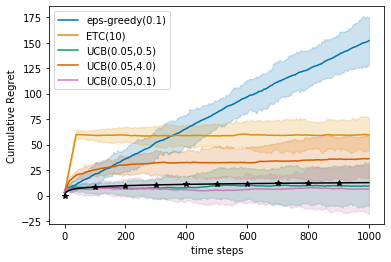

In [ ]:
plot_regret(all_data, lb=LB)

/home/vernade/Documents/cours-Telecom/LAb-Bandits-2020/display.py:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


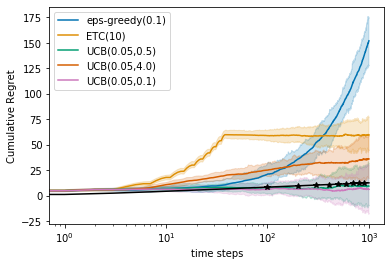

In [ ]:
plot_regret(all_data, logscale=True, lb=LB)

### Remark:
UCB does seem close to optimal... it'd be nice to see it more clearly though

/home/vernade/Documents/cours-Telecom/LAb-Bandits-2020/display.py:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


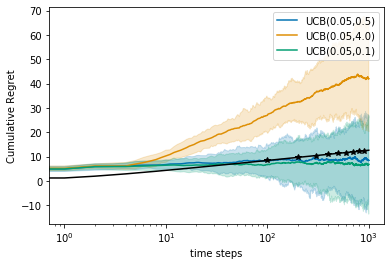

In [ ]:
agent3 = UCB(basicGaussianBandit, var=0.5, delta=0.05)
badUCB = UCB(basicGaussianBandit, var=4., delta=0.05)
lowvarUCB = UCB(basicGaussianBandit, var=0.1, delta=0.05)

all_data = experiment(basicGaussianBandit, [agent3, badUCB, lowvarUCB], Nmc=50, T=1000)
plot_regret(all_data, logscale=True, lb=LB)

/home/vernade/Documents/cours-Telecom/LAb-Bandits-2020/display.py:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


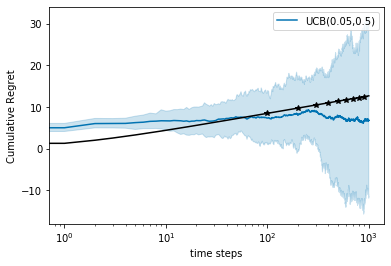

In [ ]:
all_data = experiment(basicGaussianBandit, [agent3 ], Nmc=50, T=1000)
plot_regret(all_data, logscale=True, lb=LB)

### Conclusions

What do you think ? Please write your conclusions about the optimality of UCB.